This is test task for MMD Smart done by Karina Chumak.<br>
Task: create spam/not-spam classificator using DL and clustering, provide exploratory data analysis.

In [37]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [64]:
data = pd.read_csv('data/processed_CDR_TEXT_labels.csv')

In [65]:
X = data['CDR_TEXT']

Splitting all texts into words

In [13]:
texts = X.apply(lambda x : x.split(' ')).tolist()

For this task I decided to train K-means on top of Doc2Vec model, representing each CDR_TEXT as vector and clustering vectors. This approach is described [here](https://towardsdatascience.com/automatic-topic-clustering-using-doc2vec-e1cea88449c])

In [16]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [17]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(texts)]

In [19]:
s = time.time()
model = Doc2Vec(documents, size=25, window=2, min_count=1, workers=4)
print(time.time() - s)

163.13702750205994


In [23]:
model.save('doc2vec_model')

In [ ]:
# converting each text to a vector
vectors = []
for i, t in enumerate(X):
    vectors.append(model.infer_vector(t))

In [33]:
from nltk.cluster.kmeans import KMeansClusterer

The number of clusters should be chosen by elbow method, but because running kmeans took about 3 hours for a single value of NUM_CLUSTERS = 6, I didn't implement it and leaved it the way it is. However, this has to be done in future.

In [34]:
NUM_CLUSTERS = 6

In [38]:
s = time.time()
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(vectors, assign_clusters=True)
print(time.time() - s)

9924.210003614426


In [43]:
# saving model
import pickle
save_classifier = open("kmeans.pickle","wb")
pickle.dump(kclusterer, save_classifier)
save_classifier.close()

For topic descrption I'm counting 5 most common words in each cluster

In [85]:
from collections import Counter

def get_texts_by_cluster_number(cluster):
    text_list = []
    for x in range(0, len(assigned_clusters)):
        if (assigned_clusters[x] == cluster):
            text_list.append(texts[x])
    return text_list

def get_topics(text_list):
#     flatten list of lists
    flat_list = [item for sublist in text_list for item in sublist]
    count = Counter(flat_list)
    return count.most_common()[:5]


def get_cluster_topic(id):
    return get_topics(get_texts_by_cluster_number(id))


In [88]:
for i in range(NUM_CLUSTERS):
    print('\nMost common words in {} cluster:\n{}'.format(i,get_cluster_topic(i)))


Most common words in 0 cluster:
[('httpaddr', 122568), ('org', 110791), ('g', 78143), ('va', 77493), ('klicka', 77442)]

Most common words in 1 cluster:
[('numbr', 368314), ('httpaddr', 177069), ('org', 170298), ('code', 163760), ('postal', 161385)]

Most common words in 2 cluster:
[('numbr', 475513), ('draw', 309272), ('httpaddr', 239360), ('org', 218565), ('place', 204424)]

Most common words in 3 cluster:
[('httpaddr', 117982), ('thank', 96328), ('hi', 93005), ('look', 90003), ('sign', 89563)]

Most common words in 4 cluster:
[('httpaddr', 140071), ('numbr', 101533), ('org', 87879), ('packag', 57095), ('day', 55910)]

Most common words in 5 cluster:
[('numbr', 138116), ('httpaddr', 101104), ('org', 85880), ('caro', 82543), ('attesa', 82531)]


We can see that words like 'httpaddr','numbr','org' are frequent in all the clusters, and the don't represent the content, we'll delete them for topic detection

In [91]:
def get_topics_no_trash(text_list):
#     flatten list of lists
    trash_words = ['httpaddr','numbr','org']
    flat_list = [item for sublist in text_list for item in sublist]
    clean_list = [item for item in flat_list if item not in trash_words]
    count = Counter(clean_list)
    return count.most_common()[:5]


def get_cluster_topic_no_trash(id):
    return get_topics_no_trash(get_texts_by_cluster_number(id))

In [92]:
for i in range(NUM_CLUSTERS):
    print('\nMost common words in {} cluster:\n{}'.format(i,get_cluster_topic_no_trash(i)))


Most common words in 0 cluster:
[('g', 78143), ('va', 77493), ('klicka', 77442), ('firar', 77442), ('vill', 77442)]

Most common words in 1 cluster:
[('code', 163760), ('postal', 161385), ('sort', 159993), ('sorti', 159900), ('resultat', 159899)]

Most common words in 2 cluster:
[('draw', 309272), ('place', 204424), ('novemb', 197478), ('collect', 197334), ('tesco', 197230)]

Most common words in 3 cluster:
[('thank', 96328), ('hi', 93005), ('look', 90003), ('sign', 89563), ('check', 89243)]

Most common words in 4 cluster:
[('packag', 57095), ('day', 55910), ('moneysymbnumbr', 51846), ('time', 51715), ('schedul', 50996)]

Most common words in 5 cluster:
[('caro', 82543), ('attesa', 82531), ('indirizzo', 82531), ('pacco', 82528), ('via', 32324)]


In [96]:
data['cluster'] = assigned_clusters

Let's look at clusters in spam/normal letters. Normal letters mostly belong to 2d cluster('code','postal','sort','sorti','resultat'), spam - to 5th('caro','attesa','indirizzo','pacco','via')  and 0th('klicka','firar','vill') clusters.

Text(0, 0.5, 'Percent')

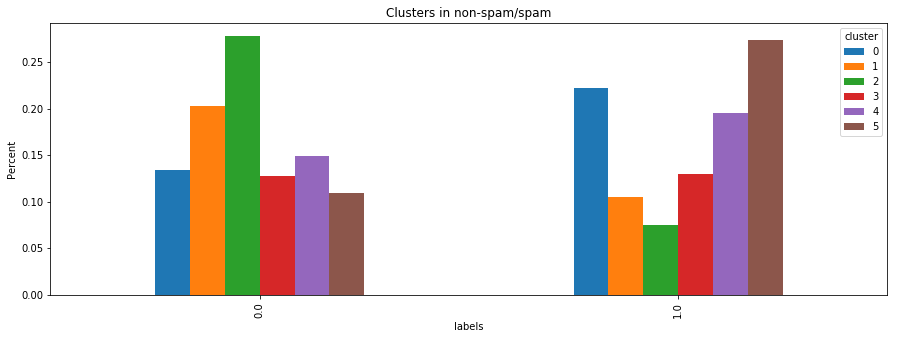

In [104]:
df_grouped = data.groupby(['labels','cluster']).size()/data.groupby(['labels']).size()
df_grouped.unstack().plot(kind='bar',figsize=(figsize),title='Clusters in non-spam/spam')
plt.ylabel("Percent")